In [ ]:
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [3]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE

pd.options.display.max_rows = 150

In [4]:
df = pd.read_csv('../data/creditcard.csv')

# standard scale Amount
ss = StandardScaler()
df['normAmount'] = ss.fit_transform(pd.DataFrame(df['Amount']))

# drop Time and Amount
df.drop(columns = ['Time','Amount'], inplace = True)

X = df.drop(columns = 'Class')
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# create SMOTE
sm = SMOTE(random_state = 42)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train.ravel())


In [5]:
# datset with stratify
X_train_sf, X_test_sf, y_train_sf, y_test_sf = train_test_split(X, y, stratify = y, random_state = 42)


X_train_sm_sf, y_train_sm_sf = sm.fit_sample(X_train_sf, y_train_sf.ravel())

''

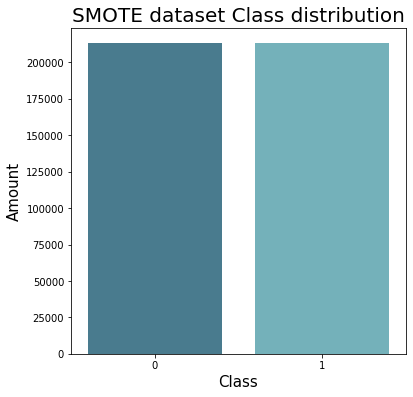

In [35]:
plt.figure(figsize = (6,6))
sns.barplot(x = [0,1], 
            y = pd.DataFrame(y_train_sm)[0].value_counts(),palette='GnBu_d')
plt.xlabel('Class', size = 15)
plt.ylabel('Amount', size = 15)
plt.title('SMOTE dataset Class distribution', size = 20)
;

In [6]:
def plot(data,metric_x,metric_y):
    plt.figure(figsize = (8,8))
    plt.plot(data[metric_x], data[f'{metric_y}_train'], c = 'b', label = 'train')
    plt.plot(data[metric_x], data[f'{metric_y}_test'], c = 'r', label = 'test')
    plt.xlabel(f'{metric_x}', size = 15)
    plt.ylabel(f'{metric_y}', size = 15)
    plt.title(f'{metric_y} vs {metric_x}', size = 25)
    plt.legend();

In [7]:
def plot_confusion_matrix(cm,title):
    plt.figure(figsize = (8,8))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    plt.xticks(ticks = [0,1],
               labels = ['predict normal','predict fraud'], 
               size = 12)
    plt.yticks(ticks = [0,1],
               labels = ['actual normal','actual fraud'], 
               size = 12)

    # cm.max() shows the larger value for class 0 and 1
    thresh = cm.max() / 2.
    
    # cm.shape = (2,2), i,j shows (0,0,1,1), (1,0,1,0)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        # cm[i,j] only works with confusion_matrix without pd.DataFrame, it shows each data in matrix
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size =20)
    plt.xlabel('Predicted label', size = 20)
    plt.title(title, size = 30)

In [6]:
def feature_importance(model,df = X_train_sm):
    predictors = [x for x in df.columns]
    feat_imp = pd.Series(model.feature_importances_,predictors).sort_values(ascending = False)
    
    plt.figure(figsize = (8,6))
    feat_imp.plot(kind = 'bar')
    plt.ylabel('Feature Importance Score')
    plt.title('Feature Importance', size = 20);

# Baseline

In [9]:
gradboost = GradientBoostingClassifier(random_state=42)
model = gradboost.fit(X_train_sm, y_train_sm.ravel())

In [10]:
prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

# TP / (TP + FP)  FP: predict fraud actual normal
recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

# TP / (TP + FN) FN: predict normal actual fraud
precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],
    'false_negative_test' : cnf_test[1,0],
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

baseline = pd.DataFrame(result,index = ['default parameter'])
baseline

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default parameter,920,10,0.973615,0.911504,0.119572,0.100684,0.980436,0.949281


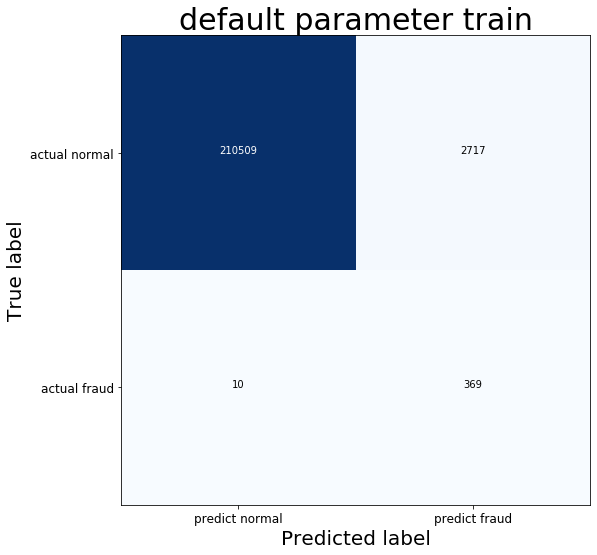

In [11]:
plot_confusion_matrix(cnf_train,'default parameter train')

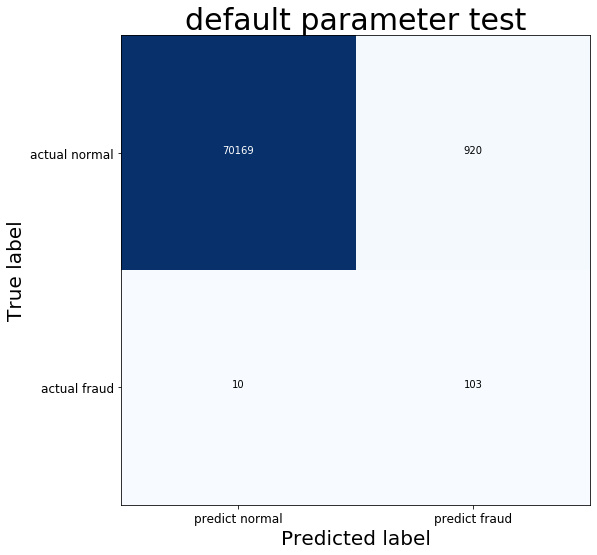

In [12]:
plot_confusion_matrix(cnf_test,'default parameter test')

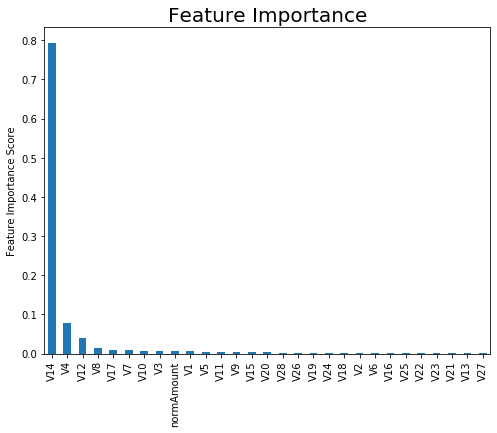

In [13]:
feature_importance(model)

# Gridsearch params

In [ ]:
# learning rate, n_estimator
# subsample
# max_depth
# min_samples_split, min_samples_leaf
# max_feature

## step 1: tuning loss, min_samples_split, main_samples_leaf

In [20]:
grid_param = {
    'loss' : ['deviance','exponential'],
    'min_samples_split': range(500,1001,100),
    'min_samples_leaf' : range(5,51,10),
}

gs1 = GridSearchCV(GradientBoostingClassifier(subsample = 0.8, 
                                             max_features='sqrt', 
                                             random_state=42), 
                  param_grid=grid_param,
                  n_jobs=-1,
                  cv = 5,
                  verbose = 10)

In [21]:
model_param = gs1.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.9min
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed: 11.9min
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed: 17.7min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed: 21.5min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed: 25.3min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed: 27.4min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed: 33.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 36.9min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 44

In [23]:
gs1.best_estimator_

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=15, min_samples_split=500,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=0.8, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [24]:
gs1.best_params_

{'loss': 'deviance', 'min_samples_leaf': 15, 'min_samples_split': 500}

In [25]:
gs1.best_score_

0.9751648522642281

In [26]:
pd.DataFrame(gs1.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_loss,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
6,117.480435,0.408856,0.256808,0.004152,deviance,15,500,"{'loss': 'deviance', 'min_samples_leaf': 15, '...",0.974675,0.974077,0.975132,0.976199,0.975742,0.975165,0.000752,1
24,114.912140,0.135441,0.244672,0.005550,deviance,45,500,"{'loss': 'deviance', 'min_samples_leaf': 45, '...",0.974370,0.973819,0.975108,0.975742,0.976129,0.975034,0.000851,2
0,116.305821,0.163662,0.284295,0.017829,deviance,5,500,"{'loss': 'deviance', 'min_samples_leaf': 5, 'm...",0.974675,0.973409,0.975284,0.976199,0.975425,0.974998,0.000931,3
18,115.570123,0.162839,0.247632,0.011708,deviance,35,500,"{'loss': 'deviance', 'min_samples_leaf': 35, '...",0.974370,0.973819,0.975073,0.975273,0.976199,0.974947,0.000812,4
12,115.449906,0.122756,0.248172,0.004372,deviance,25,500,"{'loss': 'deviance', 'min_samples_leaf': 25, '...",0.973561,0.973409,0.975132,0.976199,0.975742,0.974808,0.001133,5
19,115.037271,0.192864,0.251276,0.006704,deviance,35,600,"{'loss': 'deviance', 'min_samples_leaf': 35, '...",0.973714,0.973971,0.975261,0.975237,0.975402,0.974717,0.000721,6
13,114.915060,0.234691,0.252564,0.004152,deviance,25,600,"{'loss': 'deviance', 'min_samples_leaf': 25, '...",0.973971,0.974007,0.975261,0.975237,0.975097,0.974715,0.000595,7
7,117.475189,0.269472,0.264308,0.018149,deviance,15,600,"{'loss': 'deviance', 'min_samples_leaf': 15, '...",0.973585,0.974183,0.975261,0.975003,0.975097,0.974626,0.000640,8
20,115.262026,0.257039,0.242786,0.006394,deviance,35,700,"{'loss': 'deviance', 'min_samples_leaf': 35, '...",0.973233,0.973573,0.975050,0.974909,0.976093,0.974572,0.001044,9
16,114.631516,0.146729,0.248564,0.005313,deviance,25,900,"{'loss': 'deviance', 'min_samples_leaf': 25, '...",0.973960,0.973092,0.974616,0.975050,0.976046,0.974553,0.000997,10


# Gridsearch 1

In [27]:
gradboost_grid = GradientBoostingClassifier(loss = 'deviance',
                                            min_samples_leaf=15,
                                            min_samples_split=500,
                                            subsample= 0.8,
                                            max_features='sqrt',
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

# TP / (TP + FP)  FP: predict normal actual fraud
recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

# TP / (TP + FN) FN: predict fraud actual normal
precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],
    'false_negative_test' : cnf_test[1,0],
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = ['default parameter'])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
default parameter,902,10,0.957784,0.911504,0.120278,0.102488,0.972666,0.949408


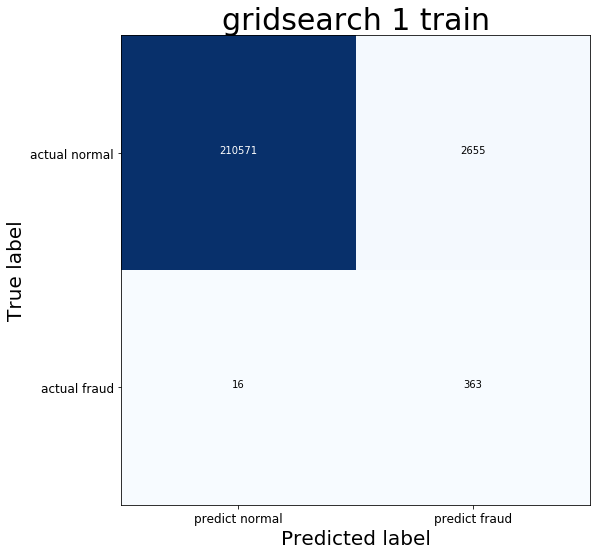

In [31]:
plot_confusion_matrix(cnf_train,'gridsearch 1 train')

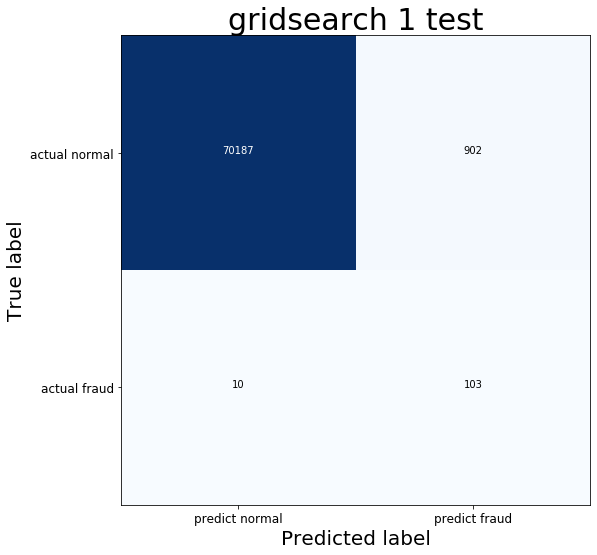

In [32]:
plot_confusion_matrix(cnf_test,'gridsearch 1 test')

''

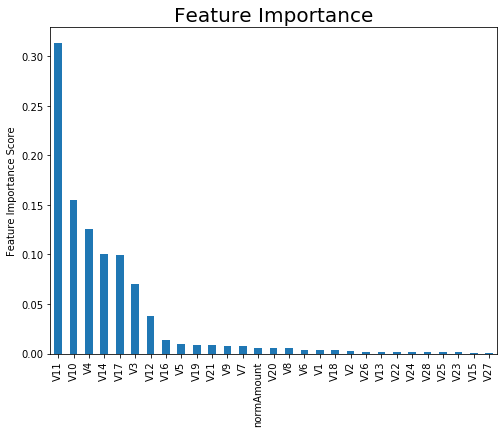

In [54]:
predictors = [x for x in X_train_sm.columns]
fea_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)

plt.figure(figsize = (8,6))
fea_imp.plot(kind = 'bar')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance', size = 20)
;

## step 2: continue minimize min_samples_split, min_samples_leaf

In [36]:
# min_samples_split: (100,501,100)
# min_samples_leaf: (5,21,5)

grid_param = {
    'loss' : ['deviance','exponential'],
    'min_samples_split': range(100,501,100),
    'min_samples_leaf' : range(5,21,5),
}

gs2 = GridSearchCV(GradientBoostingClassifier(subsample = 0.8, 
                                             max_features='sqrt', 
                                             random_state=42), 
                  param_grid=grid_param,
                  n_jobs=4,
                  cv = 5,
                  verbose = 10)

model_param = gs2.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  3.5min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  4.9min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  7.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  9.0min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 14.1min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 21.0min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 29.5min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 32.2min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 37.5min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 41.5min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 46.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 50.6min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 60.5min
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed: 72.3min
[Parallel(n_jobs=4)]: Done 173 tasks      | elapsed: 88.5min
[Parallel(

In [39]:
gs2.best_params_, gs2.best_score_

({'loss': 'deviance', 'min_samples_leaf': 10, 'min_samples_split': 500},
 0.9752234747117411)

## Gridsearch 2 

In [66]:
gradboost_grid = GradientBoostingClassifier(loss = 'deviance',
                                            min_samples_leaf=10,
                                            min_samples_split=500,
                                            subsample= 0.8,
                                            max_features='sqrt',
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

# TP / (TP + FP)  FP: predict normal actual fraud
recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

# TP / (TP + FN) FN: predict fraud actual normal
precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],
    'false_negative_test' : cnf_test[1,0],
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,910,10,0.955145,0.911504,0.119749,0.101678,0.971333,0.949352


''

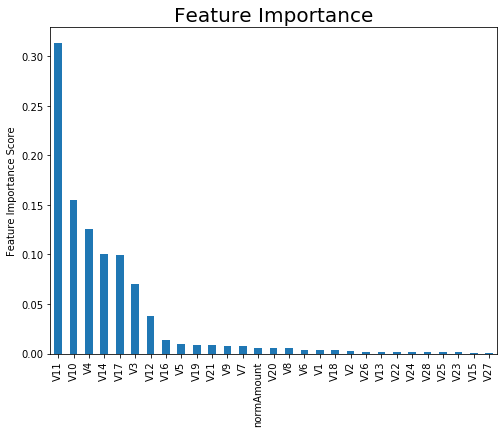

In [53]:
predictors = [x for x in X_train_sm.columns]
fea_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)

plt.figure(figsize = (8,6))
fea_imp.plot(kind = 'bar')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance', size = 20)
;

## Step 3: tune max_depth, subsample

In [48]:
# min_samples_leaf = 15, min_samples_split = 500, loss = 'deviance', max_features = 'sqrt'

grid_param = {
    'max_depth' : range(5,21,5),
    'subsample' : np.arange(0.5,1.3,0.1)
}

gs3 = GridSearchCV(GradientBoostingClassifier(max_features='sqrt',
                                              min_samples_leaf=15,
                                              min_samples_split=500,
                                              loss='deviance',
                                              random_state=42),
                  param_grid=grid_param,
                  n_jobs=4,
                  cv = 5,
                  verbose = 10)

model_param = gs3.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.9min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  9.7min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 13.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 16.3min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 19.3min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 28.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 39.9min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 43.8min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 55.7min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 76.7min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 84.9min
[Parallel(n_jobs=4)]: Done 137 tasks      | elapsed: 125.7min
[Parallel(n_jobs=4)]: Done 160 out of 160 | elapsed: 169.8min finished


In [49]:
gs3.best_params_,gs3.best_score_

({'max_depth': 20, 'subsample': 0.8999999999999999}, 0.9998639940390209)

In [52]:
pd.DataFrame(gs3.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
28,930.628171,18.458570,1.743542,0.126687,20,0.9,"{'max_depth': 20, 'subsample': 0.8999999999999...",0.999871,0.999871,0.999836,0.999871,0.999871,0.999864,0.000014,1
29,835.430521,186.040989,0.956059,0.438995,20,1,"{'max_depth': 20, 'subsample': 0.9999999999999...",0.999883,0.999859,0.999836,0.999871,0.999848,0.999859,0.000017,2
27,713.103257,35.464571,1.568856,0.211949,20,0.8,"{'max_depth': 20, 'subsample': 0.7999999999999...",0.999883,0.999871,0.999812,0.999871,0.999824,0.999852,0.000028,3
21,441.789529,13.437910,0.852463,0.208158,15,1,"{'max_depth': 15, 'subsample': 0.9999999999999...",0.999836,0.999859,0.999824,0.999859,0.999824,0.999841,0.000016,4
19,316.607836,6.168567,0.709613,0.019138,15,0.8,"{'max_depth': 15, 'subsample': 0.7999999999999...",0.999824,0.999859,0.999801,0.999824,0.999824,0.999826,0.000019,5
26,639.087636,2.084573,1.596256,0.039475,20,0.7,"{'max_depth': 20, 'subsample': 0.7}",0.999871,0.999824,0.999789,0.999848,0.999801,0.999826,0.000030,6
20,377.939517,14.844845,0.810966,0.106461,15,0.9,"{'max_depth': 15, 'subsample': 0.8999999999999...",0.999789,0.999836,0.999824,0.999859,0.999801,0.999822,0.000025,7
25,550.039159,6.679788,1.578274,0.097739,20,0.6,"{'max_depth': 20, 'subsample': 0.6}",0.999824,0.999824,0.999801,0.999824,0.999812,0.999817,0.000009,8
24,361.733806,67.308197,1.382984,0.253031,20,0.5,"{'max_depth': 20, 'subsample': 0.5}",0.999801,0.999824,0.999812,0.999789,0.999836,0.999812,0.000017,9
17,233.083573,1.461243,0.684950,0.006897,15,0.6,"{'max_depth': 15, 'subsample': 0.6}",0.999848,0.999766,0.999789,0.999777,0.999812,0.999798,0.000029,10


## Gridsearch 3

In [69]:
# min_samples_leaf = 15, min_samples_split = 500, loss = 'deviance', max_features = 'sqrt'
# max_depth = 20, subsample = 0.9

gradboost_grid = GradientBoostingClassifier(min_samples_leaf=15, 
                                        min_samples_split=500, 
                                        loss = 'deviance', 
                                        max_features = 'sqrt', 
                                        max_depth=20, 
                                        subsample=0.9, 
                                        random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

In [70]:
prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],    # tested by precision
    'false_negative_test' : cnf_test[1,0],    # tested by recall
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,21,16,1.0,0.858407,1.0,0.822034,1.0,0.929056


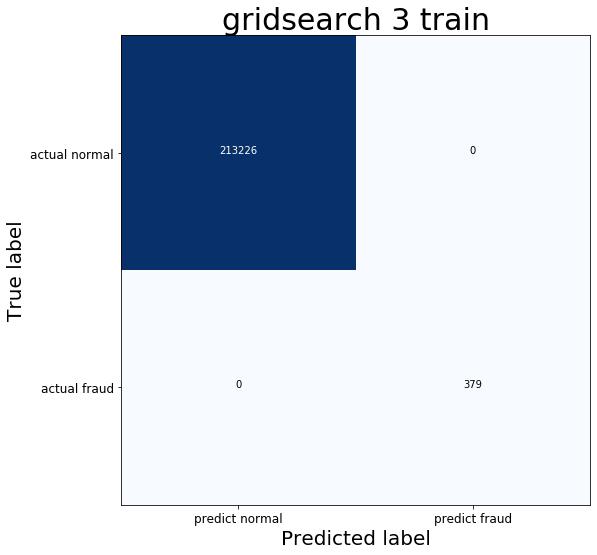

In [72]:
plot_confusion_matrix(cnf_train,'gridsearch 3 train')

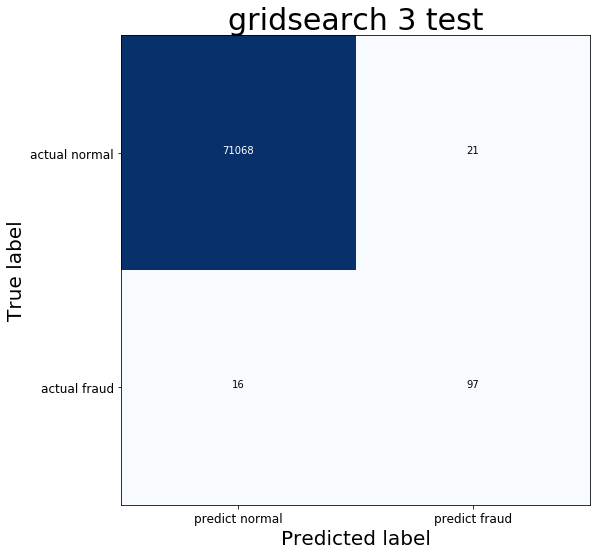

In [74]:
plot_confusion_matrix(cnf_test,'gridsearch 3 test')

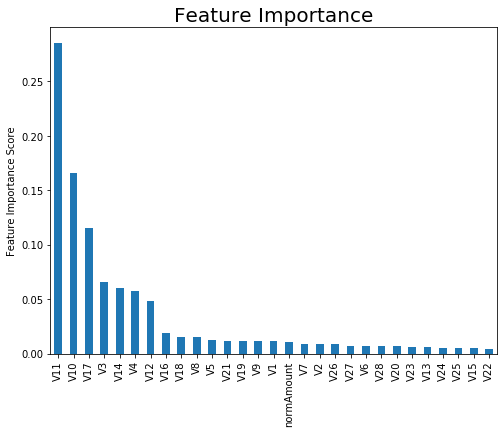

In [75]:
predictors = [x for x in X_train_sm.columns]
fea_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)

plt.figure(figsize = (8,6))
fea_imp.plot(kind = 'bar')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance', size = 20);

## step 4: tuning n_estimators and learning_rate

In [77]:
# min_samples_leaf = 15, min_samples_split = 500, loss = 'deviance', max_features = 'sqrt'
# max_depth = 20 (could continue increase), subsample = 0.9

grid_param = {
    'n_estimators': range(20,101,10),
    'learning_rate':[0.1,0.05,0.01]
}

gs4 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=15, 
                                              min_samples_split=500, 
                                              loss = 'deviance', 
                                              max_features = 'sqrt', 
                                              max_depth=20, 
                                              subsample=0.9, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs4.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  2.8min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:  5.7min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 11.6min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 18.1min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 30.9min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 45.4min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 51.9min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 64.4min
[Parallel(n_jobs=4)]: Done  77 tasks      | elapsed: 98.7min
[Parallel(n_jobs=4)]: Done  90 tasks      | elapsed: 136.1min
[Parallel(n_jobs=4)]: Done 105 tasks      | elapsed: 156.0min
[Parallel(n_jobs=4)]: Done 120 tasks      | elapsed: 193.9min
[Parallel(n_jobs=4)]: Done 135 out of 135 | elapsed: 237.1min finished


In [78]:
gs4.best_params_, gs4.best_score_

({'learning_rate': 0.1, 'n_estimators': 100}, 0.9998639940390209)

In [79]:
pd.DataFrame(gs4.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,412.806917,3.840072,0.839668,0.022967,0.1,100,"{'learning_rate': 0.1, 'n_estimators': 100}",0.999871,0.999871,0.999836,0.999871,0.999871,0.999864,0.000014,1
7,371.563456,0.685723,0.757834,0.002099,0.1,90,"{'learning_rate': 0.1, 'n_estimators': 90}",0.999871,0.999848,0.999812,0.999859,0.999871,0.999852,0.000022,2
6,337.700125,0.554651,0.697015,0.004253,0.1,80,"{'learning_rate': 0.1, 'n_estimators': 80}",0.999859,0.999836,0.999812,0.999859,0.999848,0.999843,0.000018,3
5,298.125615,0.772921,0.622495,0.005123,0.1,70,"{'learning_rate': 0.1, 'n_estimators': 70}",0.999836,0.999824,0.999801,0.999824,0.999836,0.999824,0.000013,4
4,259.324065,1.059535,0.551035,0.010841,0.1,60,"{'learning_rate': 0.1, 'n_estimators': 60}",0.999836,0.999824,0.999789,0.999812,0.999777,0.999808,0.000022,5
3,221.025045,0.676592,0.460513,0.002759,0.1,50,"{'learning_rate': 0.1, 'n_estimators': 50}",0.999824,0.999812,0.999766,0.999754,0.999742,0.999780,0.000033,6
17,864.364725,15.315073,1.644636,0.189258,0.05,100,"{'learning_rate': 0.05, 'n_estimators': 100}",0.999766,0.999789,0.999766,0.999766,0.999766,0.999770,0.000009,7
16,748.632384,14.422334,1.447761,0.135645,0.05,90,"{'learning_rate': 0.05, 'n_estimators': 90}",0.999719,0.999766,0.999742,0.999754,0.999766,0.999749,0.000018,8
15,622.531859,42.870637,1.472425,0.104377,0.05,80,"{'learning_rate': 0.05, 'n_estimators': 80}",0.999672,0.999777,0.999719,0.999742,0.999766,0.999735,0.000038,9
2,175.594201,1.828780,0.379590,0.007577,0.1,40,"{'learning_rate': 0.1, 'n_estimators': 40}",0.999683,0.999730,0.999742,0.999695,0.999707,0.999712,0.000022,10


- default parameters for n_estimators and learning_rate

## Step 5: continue with learning_rate and n_estimators

In [84]:
grid_param = {
    'n_estimators': [50,100,300,500],
    'learning_rate':[0.05, 0.1, 0.3, 0.5]
}

gs5 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=25, 
                                              min_samples_split=500, 
                                              loss = 'deviance', 
                                              max_features = 'sqrt', 
                                              max_depth=50, 
                                              subsample=0.9, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs5.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:  8.2min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 21.2min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 51.4min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 62.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 77.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 92.2min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed: 101.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed: 110.2min
[Parallel(n_jobs=4)]: Done  80 out of  80 | elapsed: 124.7min finished


In [85]:
gs5.best_params_, gs5.best_score_

({'learning_rate': 0.1, 'n_estimators': 300}, 0.9998710288613916)

In [86]:
gs4.best_score_

0.9998639940390209

# gridsearch 5

In [87]:
# n_estimator = 300
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=15, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 'sqrt',
                                            learning_rate=0.1,
                                            n_estimators=300,
                                            max_depth=20, 
                                            subsample=0.9, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],    # tested by precision
    'false_negative_test' : cnf_test[1,0],    # tested by recall
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,20,14,1.0,0.876106,1.0,0.831933,1.0,0.937912


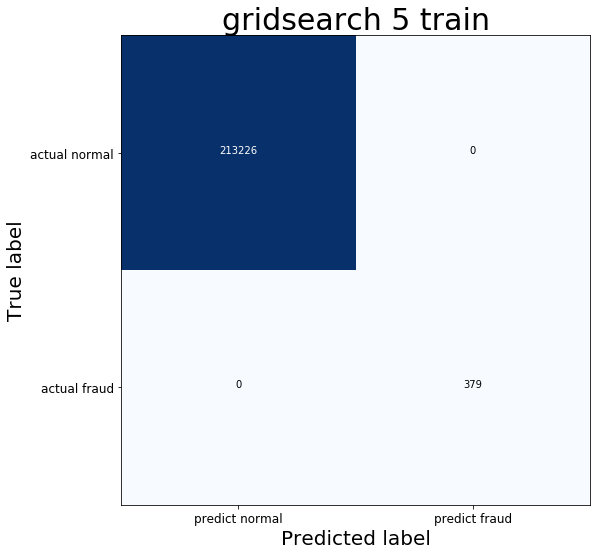

In [88]:
plot_confusion_matrix(cnf_train, 'gridsearch 5 train')

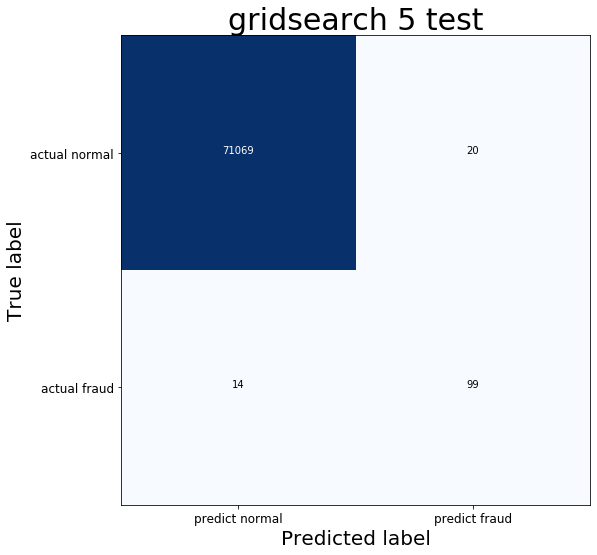

In [89]:
plot_confusion_matrix(cnf_test, 'gridsearch 5 test')

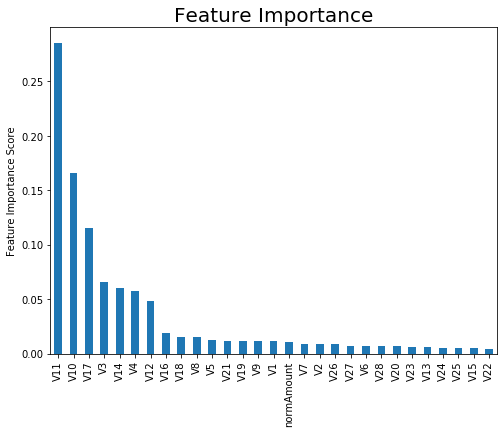

In [90]:
predictors = [x for x in X_train_sm.columns]
fea_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)

plt.figure(figsize = (8,6))
fea_imp.plot(kind = 'bar')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance', size = 20);

## step 6 tuning max_features

In [92]:
# total 29 features  (len(predictors))
grid_param = {
    'max_features': ['sqrt','auto','log2',8,9,10,11]
}

gs6 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=15, 
                                              min_samples_split=500, 
                                              loss = 'deviance',
                                              n_estimators=300,
                                              learning_rate=0.1,
                                              max_depth=20, 
                                              subsample=0.9, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs6.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 17.0min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 63.5min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 82.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 108.8min
[Parallel(n_jobs=4)]: Done  32 out of  35 | elapsed: 139.1min remaining: 13.0min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 151.6min finished


In [93]:
gs6.best_params_,gs6.best_score_

({'max_features': 8}, 0.9998733736922082)

In [94]:
gs5.best_score_

0.9998710288613916

In [96]:
pd.DataFrame(gs6.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,714.867111,7.501631,0.882723,0.012728,8,{'max_features': 8},0.999894,0.999894,0.999836,0.999883,0.999859,0.999873,0.000023,1
0,523.927933,18.398926,0.964541,0.016177,sqrt,{'max_features': 'sqrt'},0.999871,0.999871,0.999836,0.999883,0.999894,0.999871,0.000020,2
5,862.175586,9.545856,0.854844,0.007438,10,{'max_features': 10},0.999871,0.999894,0.999836,0.999894,0.999848,0.999869,0.000024,3
6,912.044247,48.557405,0.772820,0.079812,11,{'max_features': 11},0.999871,0.999848,0.999848,0.999883,0.999883,0.999866,0.000016,4
2,401.480472,6.834606,0.973466,0.029469,log2,{'max_features': 'log2'},0.999906,0.999871,0.999836,0.999848,0.999848,0.999862,0.000025,5
4,793.907471,7.970451,0.864000,0.018092,9,{'max_features': 9},0.999871,0.999883,0.999824,0.999883,0.999824,0.999857,0.000027,6
1,2755.981218,93.514662,0.886383,0.026501,auto,{'max_features': 'auto'},0.999883,0.999871,0.999824,0.999848,0.999848,0.999855,0.000020,7


## gridsearch 6

In [97]:
# max_features = 8
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=15, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 8,
                                            learning_rate=0.1,
                                            n_estimators=300,
                                            max_depth=20, 
                                            subsample=0.9, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],    # tested by precision
    'false_negative_test' : cnf_test[1,0],    # tested by recall
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,23,15,1.0,0.867257,1.0,0.809917,1.0,0.933467


## step 7: follow step 5, increase max_depth

In [98]:
grid_param = {
    'max_depth': range(20,51,5)
}

gs7 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=15, 
                                              min_samples_split=500, 
                                              loss = 'deviance', 
                                              max_features = 'sqrt', 
                                              learning_rate=0.1,
                                              n_estimators=300,
                                              subsample=0.9, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs7.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 15.1min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 24.0min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 41.2min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 51.9min
[Parallel(n_jobs=4)]: Done  32 out of  35 | elapsed: 81.0min remaining:  7.6min
[Parallel(n_jobs=4)]: Done  35 out of  35 | elapsed: 96.4min finished


In [99]:
gs7.best_params_, gs7.best_score_

({'max_depth': 50}, 0.9998780636012821)

In [100]:
gs6.best_score_, gs5.best_score_

(0.9998733736922082, 0.9998710288613916)

# gridsearch 7

In [101]:
# max_depth = 50
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=15, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 'sqrt',
                                            learning_rate=0.1,
                                            n_estimators=300,
                                            max_depth=50, 
                                            subsample=0.9, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],    # tested by precision
    'false_negative_test' : cnf_test[1,0],    # tested by recall
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,26,16,1.0,0.858407,1.0,0.788618,1.0,0.929021


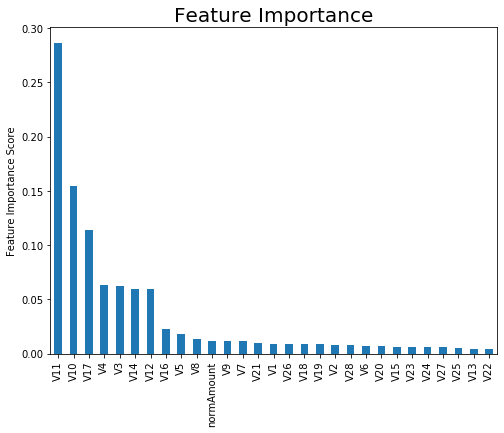

In [102]:
predictors = [x for x in X_train_sm.columns]
fea_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)

plt.figure(figsize = (8,6))
fea_imp.plot(kind = 'bar')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance', size = 20);

# Best Model: gs5

## step & gridsearch 8: tuning n_est and learning_rate for gs5

In [109]:
# gs5 learning_rate / 2
# gs5 n_estimator *2
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=15, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 'sqrt',
                                            learning_rate=0.05,
                                            n_estimators=600,
                                            max_depth=20, 
                                            subsample=0.9, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],    # tested by precision
    'false_negative_test' : cnf_test[1,0],    # tested by recall
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,24,15,1.0,0.867257,1.0,0.803279,1.0,0.93346


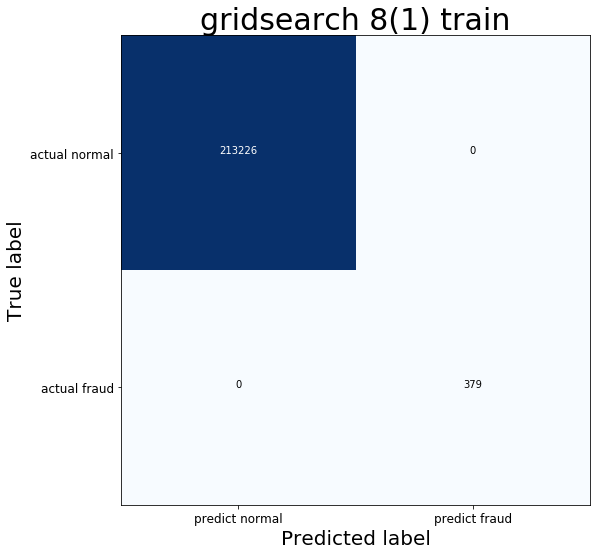

In [110]:
plot_confusion_matrix(cnf_train,'gridsearch 8(1) train')

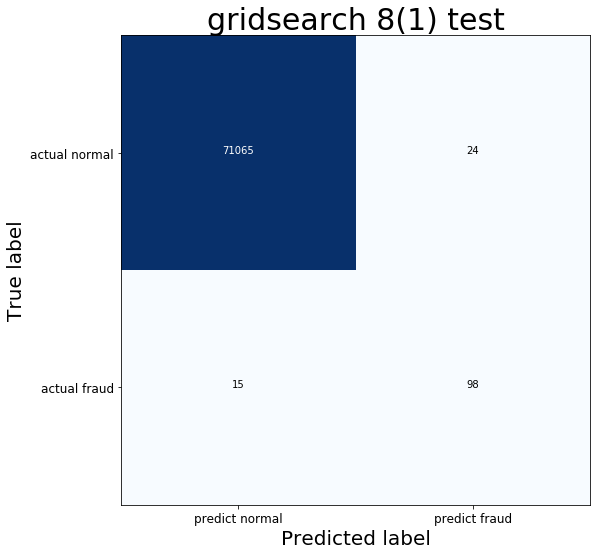

In [111]:
plot_confusion_matrix(cnf_test,'gridsearch 8(1) test')

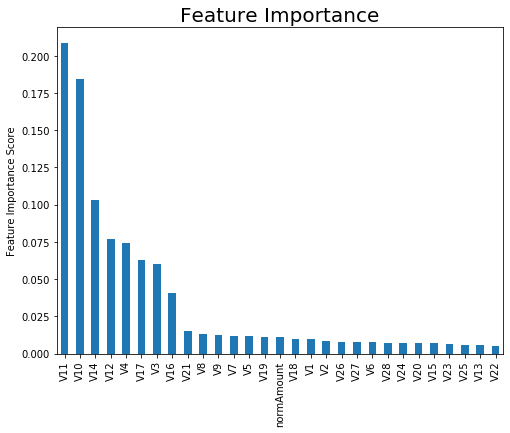

In [112]:
predictors = [x for x in X_train_sm.columns]
fea_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)

plt.figure(figsize = (8,6))
fea_imp.plot(kind = 'bar')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance', size = 20);

In [105]:
# gs5 learning_rate / 5
# gs5 n_estimator *5
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=15, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 'sqrt',
                                            learning_rate=0.02,
                                            n_estimators= 1500,
                                            max_depth=20, 
                                            subsample=0.9, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],    # tested by precision
    'false_negative_test' : cnf_test[1,0],    # tested by recall
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,21,16,1.0,0.858407,1.0,0.822034,1.0,0.929056


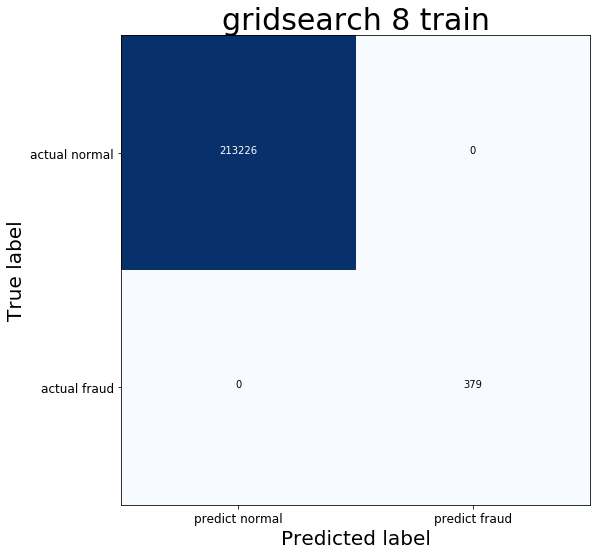

In [106]:
plot_confusion_matrix(cnf_train, 'gridsearch 8 train')

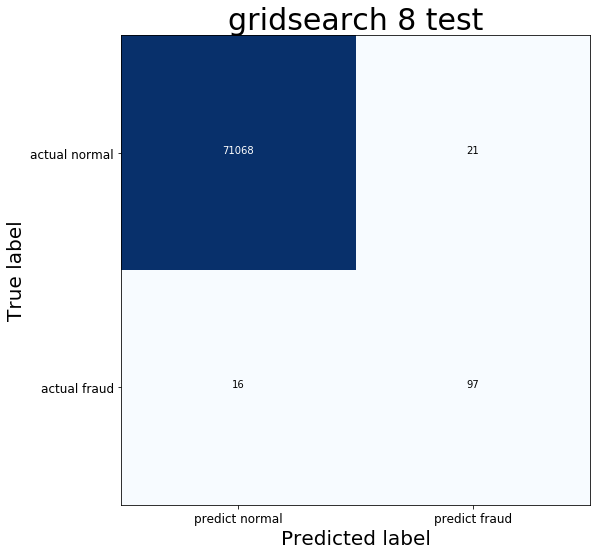

In [107]:
plot_confusion_matrix(cnf_test, 'gridsearch 8 test')

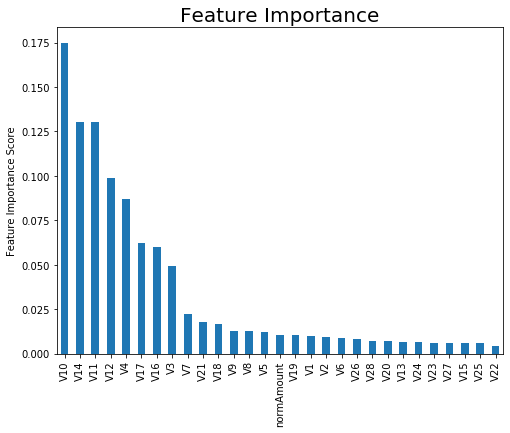

In [108]:
predictors = [x for x in X_train_sm.columns]
fea_imp = pd.Series(model.feature_importances_, predictors).sort_values(ascending = False)

plt.figure(figsize = (8,6))
fea_imp.plot(kind = 'bar')
plt.ylabel('Feature Importance Score')
plt.title('Feature Importance', size = 20);

## step 9: tuning max_depth for gs5

In [7]:
grid_param = {
    'max_depth': range(20,101,10)
}

gs9 = GridSearchCV(GradientBoostingClassifier(min_samples_leaf=15, 
                                              min_samples_split=500, 
                                              loss = 'deviance', 
                                              max_features = 'sqrt', 
                                              learning_rate=0.1,
                                              n_estimators=300,
                                              subsample=0.9, 
                                              random_state=42), 
                   param_grid=grid_param,
                   n_jobs=4,
                   cv = 5,
                   verbose = 10)

model_param = gs9.fit(X_train_sm, y_train_sm.ravel())

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed: 18.7min
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed: 29.3min
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed: 47.9min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed: 59.4min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed: 85.8min
[Parallel(n_jobs=4)]: Done  43 out of  45 | elapsed: 106.0min remaining:  4.9min
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 116.5min finished


In [9]:
gs9.best_params_, gs9.best_score_

({'max_depth': 50}, 0.9998780636012821)

In [11]:
pd.DataFrame(gs9.cv_results_).sort_values(by = 'rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
3,585.684065,17.943263,1.148046,0.039948,50,{'max_depth': 50},0.999883,0.999894,0.999859,0.999859,0.999894,0.999878,0.000016,1
4,612.688646,21.497387,1.197594,0.059796,60,{'max_depth': 60},0.999883,0.999906,0.999848,0.999894,0.999859,0.999878,0.000022,2
5,566.050468,19.435246,1.140587,0.048946,70,{'max_depth': 70},0.999883,0.999906,0.999848,0.999894,0.999848,0.999876,0.000024,3
6,545.424118,14.028388,1.123151,0.003430,80,{'max_depth': 80},0.999883,0.999906,0.999848,0.999894,0.999848,0.999876,0.000024,3
7,552.833310,16.821928,1.205308,0.125777,90,{'max_depth': 90},0.999883,0.999906,0.999848,0.999894,0.999848,0.999876,0.000024,3
8,601.118209,58.290849,1.321774,0.387411,100,{'max_depth': 100},0.999883,0.999906,0.999848,0.999894,0.999848,0.999876,0.000024,3
2,575.544778,16.906381,1.180340,0.028217,40,{'max_depth': 40},0.999859,0.999894,0.999859,0.999883,0.999871,0.999873,0.000014,7
1,614.441353,24.532618,1.169288,0.155222,30,{'max_depth': 30},0.999894,0.999871,0.999859,0.999894,0.999848,0.999873,0.000019,8
0,548.914501,19.874703,1.083589,0.094646,20,{'max_depth': 20},0.999871,0.999871,0.999836,0.999883,0.999894,0.999871,0.000020,9


## gridsearch 9

In [12]:
# max_depth = 50
gradboost_grid = GradientBoostingClassifier(min_samples_leaf=15, 
                                            min_samples_split=500, 
                                            loss = 'deviance', 
                                            max_features = 'sqrt',
                                            learning_rate=0.1,
                                            n_estimators=300,
                                            max_depth=50, 
                                            subsample=0.9, 
                                            random_state=42)
model = gradboost_grid.fit(X_train_sm, y_train_sm.ravel())

prediction_train = model.predict(X_train)
prediction_test = model.predict(X_test)

cnf_train = confusion_matrix(y_train, prediction_train)
cnf_test = confusion_matrix(y_test, prediction_test)

recall_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[1,0])
recall_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[1,0])

precision_train = cnf_train[1,1] / (cnf_train[1,1] + cnf_train[0,1])
precision_test = cnf_test[1,1] / (cnf_test[1,1] + cnf_test[0,1])

roc_train = roc_auc_score(y_train, prediction_train)
roc_test = roc_auc_score(y_test, prediction_test)

result = {
    'false_positive_test' : cnf_test[0,1],    # tested by precision
    'false_negative_test' : cnf_test[1,0],    # tested by recall
    'recall_train' : recall_train, 
    'recall_test' : recall_test,
    'precision_train' : precision_train, 
    'precision_test' : precision_test,
    'roc_train' : roc_train,
    'roc_test' : roc_test,
}

grid = pd.DataFrame(result,index = [1])
grid

,false_positive_test,false_negative_test,recall_train,recall_test,precision_train,precision_test,roc_train,roc_test
1,26,16,1.0,0.858407,1.0,0.788618,1.0,0.929021


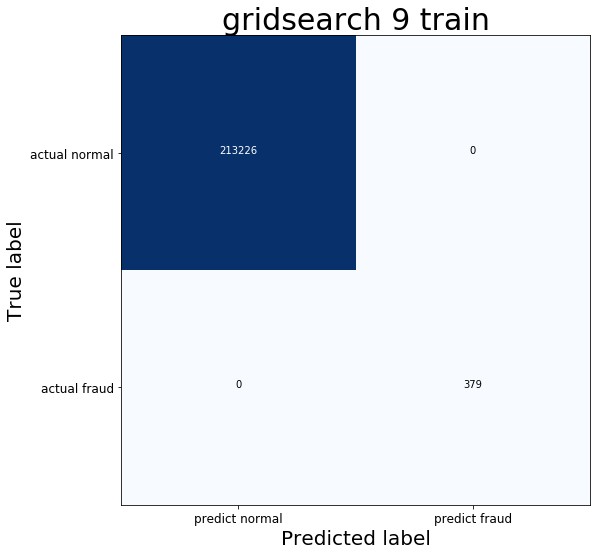

In [13]:
plot_confusion_matrix(cnf_train,'gridsearch 9 train')

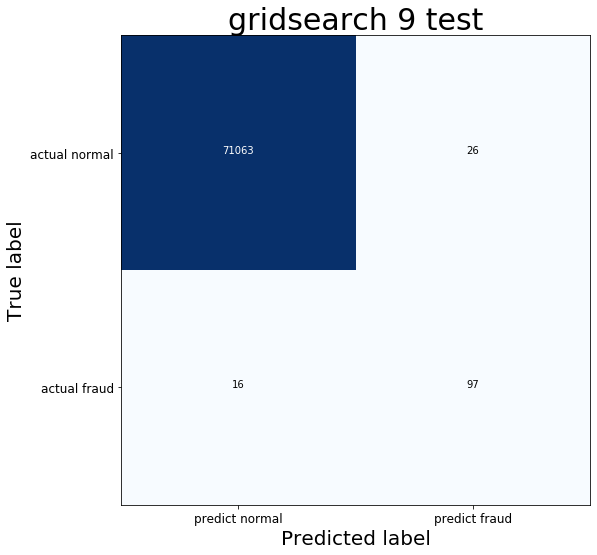

In [14]:
plot_confusion_matrix(cnf_test,'gridsearch 9 test')

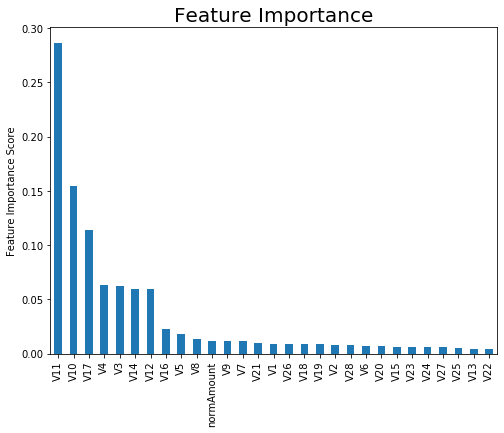

In [15]:
feature_importance(model)

## Summary used

- 1 gs2: min_samples_leaf, min_samples_split
- 2 gs3: max_depth, subsample
- 3 gs5: n_estimators, learning_rate
- 4 gs8(0): n_estimators, learning_rate by 5